# Computer Vision Project

### Setup

In [152]:
%load_ext autoreload
%autoreload 2
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
from segmentation.show import *

from models.unet_model import UNET


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [173]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [174]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_augmentation = preprocessing.get_training_augmentation()


train_dataset = CVDataset(x_train_fps, y_train_fps, preprocessing=preprocessing_fn, augmentation=train_augmentation)
valid_dataset = CVDataset(x_val_fps, y_val_fps)


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735
Testing dataset has size 3694


In [188]:
from models.unet_model import UNET
from segmentation.eval import *
from segmentation.eval import CVDatasetPredictions
from segmentation.metrics import *
from segmentation.pertrubations import *
from segmentation.show import *


In [189]:
petrubaiton = CustomScaling(10)


test_dataset  = CVDataset(
                x_test_fps[:10],
                y_test_fps[:10],
                augmentation= petrubaiton,
                preprocessing=preprocessing_fn
                )

model = UNET()
eval_ds = CVDatasetPredictions(test_dataset, 'cpu')
eval_ds.set_prediction_fn(predict, model = model, device = 'cpu')

In [191]:
eval_ds.compute_accuracy(ignore_class=255, progress_bar=True)

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


0.6847

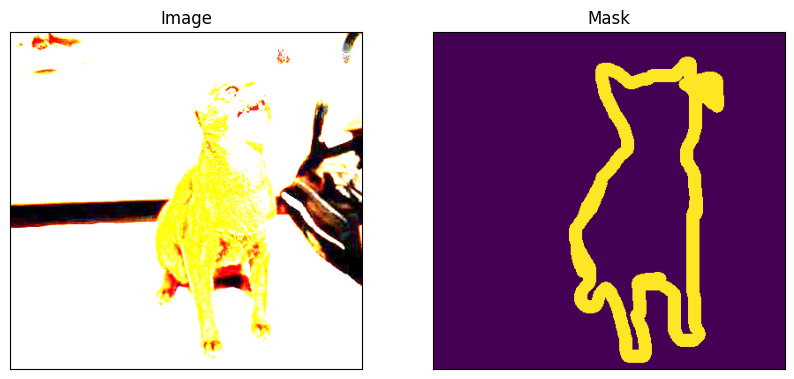

In [150]:
image, mask = test_dataset[1]
visualise_data(image = image, mask = mask)